In [170]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

## Загрузка данных

In [171]:
df = pd.read_csv('T_games_dataset.csv')

### Общая предобработка данных

In [172]:

df['order_date'] = pd.to_datetime(df['order_day'])
df.drop('order_day', axis=1, inplace=True)
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.day
df['purchased_on_discount'] = df['category_name'] == 'Скидки'

df['good_type'] = df['good_name'].apply(lambda x: 'DLC' if 'DLC' in x else 'Game')
df['is_DLC'] = df['good_type'] == 'DLC'

## Гипотеза 1

Клиенты с высоким уровнем образования чаще приобретают DLC для игр, так как они более осведомлены о новых возможностях и расширениях для игр.

### Предобработка для этой гипотезы

In [173]:
edu_lvl_grade = {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}
edu_lvl_by_grade = {v: k for k, v in edu_lvl_grade.items()}


df['edu_lvl_grade'] = df['education_level'].map(edu_lvl_grade)
highest_edu_lvl_by_client = df.groupby('client_id')['education_level'].apply(lambda x: edu_lvl_by_grade[x.map(edu_lvl_grade).max()])
min_age_by_client = df.groupby('client_id')['age'].min()
max_age_by_client = df.groupby('client_id')['age'].max()
mean_income_by_id = df.groupby('client_id')['monthly_income_amt'].mean()


df['min_age'] = df['client_id'].map(min_age_by_client)
df['max_age'] = df['client_id'].map(max_age_by_client)
df['education_level'] = df['client_id'].map(highest_edu_lvl_by_client)
df['mean_income'] = df['client_id'].map(mean_income_by_id)

In [194]:
df = df[df['max_age'] - df['min_age'] <= 3]
df.drop_duplicates(subset=['client_id', 'good_name'], inplace=True)

<AxesSubplot: xlabel='edu_lvl_grade'>

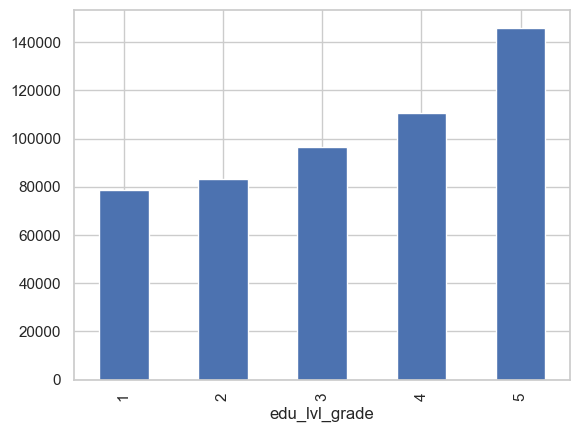

In [189]:
df.drop_duplicates(subset=['client_id']).groupby('edu_lvl_grade')['mean_income'].mean().plot(kind='bar')

### Чистка выбросов для данной гипотезы

In [5]:
df1 = df.copy()

df1 = df1[(df1['min_age'] >= 27) & (df1['max_age'] <= 45)]

print(f'Размер датасета после фильтрации: {df1.shape[0] / df.shape[0] * 100:.2f}% от исходного')

Размер датасета после фильтрации: 44.89% от исходного


In [6]:
df1['education_level'].value_counts()

GRD    24209
SCH     6464
UGR     5277
PGR     3173
ACD      698
Name: education_level, dtype: int64

### Вспомогательное поле для гипотезы 1

### Проверка гипотезы

In [110]:
mean_dlc_to_all_ratio = df1.groupby(['education_level', 'client_id'])[
    'is_DLC'].mean().groupby('education_level').mean().sort_values()
mean_dlc_to_all_ratio

education_level
UGR    0.126459
SCH    0.127558
GRD    0.159985
PGR    0.180081
ACD    0.187924
Name: is_DLC, dtype: float64

In [14]:
import seaborn as sns

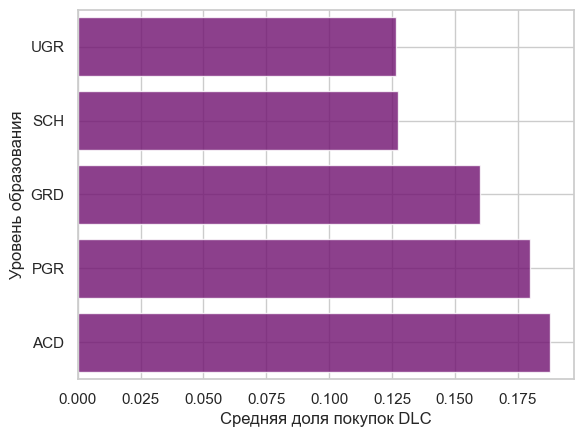

In [28]:
sns.barplot(x=mean_dlc_to_all_ratio.values, y=mean_dlc_to_all_ratio.index, color='purple', orient='h', alpha=0.8)
plt.xlabel('Средняя доля покупок DLC')
plt.ylabel('Уровень образования')
plt.grid(True)

### Статистический анализ

In [26]:
from scipy.stats import norm

def z_test(lvl1, lvl2):
    p1, p2 = mean_dlc_to_all_ratio[lvl1], mean_dlc_to_all_ratio[lvl2]
    n1, n2 = df1[df1['education_level'] == lvl1].shape[0], df1[df1['education_level'] == lvl2].shape[0]
    
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    z = (p1 - p2) / (p * (1 - p) * (1 / n1 + 1 / n2)) ** 0.5
    
    p_value = 2 * (1 - norm.cdf(abs(z)))

    return p_value
    
edu_lvls = mean_dlc_to_all_ratio.index
p_values = pd.DataFrame(index=edu_lvls, columns=edu_lvls)
equals_df = pd.DataFrame(index=edu_lvls, columns=edu_lvls)
for lvl1 in edu_lvls:
    for lvl2 in edu_lvls:
        p = z_test(lvl1, lvl2)
        p_values.loc[lvl1, lvl2] = p
        equals_df.loc[lvl1, lvl2] = 'equal' if p > 0.05 else 'not equal'

p_values

education_level,UGR,SCH,GRD,PGR,ACD
education_level,,,,,
UGR,1.0,0.858864,0.0,0.0,0.000007
SCH,0.858864,1.0,0.0,0.0,0.000008
GRD,0.0,0.0,1.0,0.003895,0.047567
PGR,0.0,0.0,0.003895,1.0,0.626419
ACD,0.000007,0.000008,0.047567,0.626419,1.0


In [27]:
equals_df

education_level,UGR,SCH,GRD,PGR,ACD
education_level,,,,,
UGR,equal,equal,not equal,not equal,not equal
SCH,equal,equal,not equal,not equal,not equal
GRD,not equal,not equal,equal,not equal,not equal
PGR,not equal,not equal,not equal,equal,equal
ACD,not equal,not equal,not equal,equal,equal


----

In [196]:
df1 = df.copy()

df1 = df1[(df1['min_age'] >= 14) & (df1['max_age'] < 55)]

print(f'Размер датасета после фильтрации: {df1.shape[0] / df.shape[0] * 100:.2f}% от исходного')

Размер датасета после фильтрации: 97.29% от исходного


In [197]:
len(df1)

80611

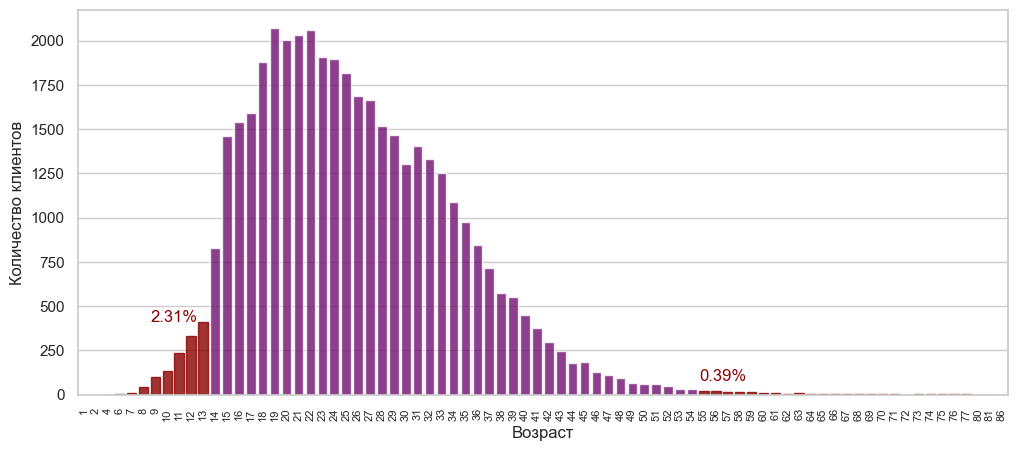

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

bars = df.drop_duplicates(subset=['client_id', 'age']).groupby('age').size()
plt.figure(figsize=(12, 5))
plt.grid(True)
ax = sns.barplot(x=bars.index, y=bars.values, color='purple', alpha=0.8)

older_than_55 = df[df['age'] >= 55].shape[0] / df.shape[0]
younger_than_14 = df[df['age'] < 14].shape[0] / df.shape[0]

for b in ax.patches:
    if 1 <= b.get_x() < 10 or 51 <= b.get_x() <= 86:
        b.set_color('darkred')
    if 50 <= b.get_x() <= 51:
        ax.annotate(f'{older_than_55 * 100:.2f}%', (b.get_x() + 1, b.get_height() + 50), fontsize=12, color='darkred')
    if 9 <= b.get_x() <= 10:
        ax.annotate(f'{younger_than_14 * 100:.2f}%', (b.get_x() - 4, b.get_height()), fontsize=12, color='darkred')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()


In [199]:
def find_w0_w1(x, y):
    w1 = ((x - x.mean()) * (y - y.mean())).sum() / ((x - x.mean()) ** 2).sum()
    w0 = y.mean() - w1 * x.mean()
    return w0, w1

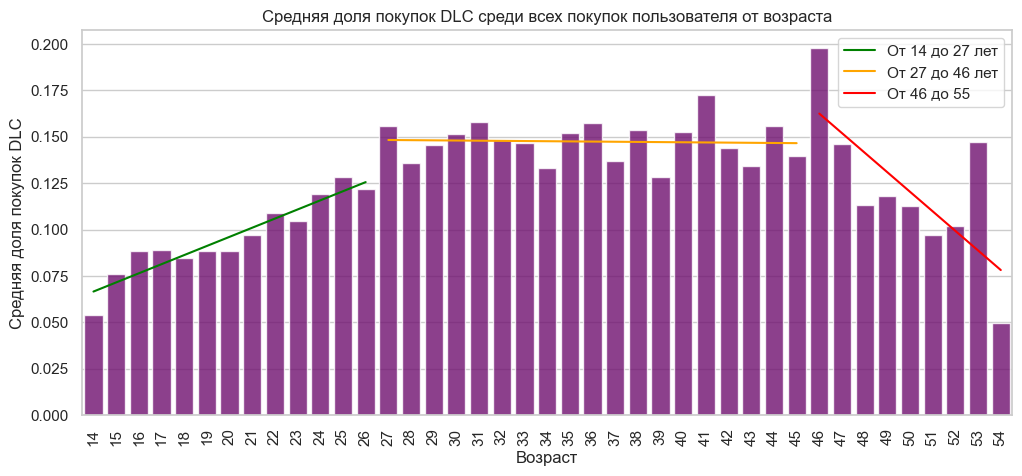

In [208]:
fig = plt.figure(figsize=(12, 5))

X1 = np.arange(14, 27)
y1 = df1[df1['age'].isin(X1)].groupby(['age', 'client_id'])['is_DLC'].mean().groupby('age').mean().values

X2 = np.arange(27, 46)
y2 = df1[df1['age'].isin(X2)].groupby(['age', 'client_id'])['is_DLC'].mean().groupby('age').mean().values

X3 = np.arange(46, 55)
y3 = df1[df1['age'].isin(X3)].groupby(['age', 'client_id'])['is_DLC'].mean().groupby('age').mean().values

w0_1, w1_1 = find_w0_w1(X1, y1)
w0_2, w1_2 = find_w0_w1(X2, y2)
w0_3, w1_3 = find_w0_w1(X3, y3)

plt.plot(X1 - 14, w0_1 + w1_1 * np.array(X1), color='green', label="От 14 до 27 лет")
plt.plot(X2 - 14, w0_2 + w1_2 * np.array(X2), color='orange', label = "От 27 до 46 лет")
plt.plot(X3 - 14, w0_3 + w1_3 * np.array(X3),
            color='red', label="От 46 до 55")
plt.legend()


plt.title("Средняя доля покупок DLC среди всех покупок пользователя от возраста")


mean_dlc_by_age = df1.groupby(['age', 'client_id'])['is_DLC'].mean().groupby('age').mean()
sns.barplot(x=mean_dlc_by_age.index, y=mean_dlc_by_age.values, color='purple', alpha=0.8)
plt.xticks(rotation=90)
plt.xlabel("Возраст")


plt.ylabel("Средняя доля покупок DLC")

plt.scatter()


plt.show()

## Гипотеза 2
Мужчины чаще покупают игры из категории "экшн" или "шутеры", в то время как женщины предпочитают игры из категории "пазлы" или "симуляторы".

### Предобработка для этой гипотезы

In [6]:
df2 = df.copy()

Некоторые товары имеют несколько категорий, поэтому для каждого товара выбирается самая часто встречающаяся категория.

In [7]:
# df2 = df2[df2['good_type] != 'DLC']
category_by_name = df2.groupby('good_name')['category_name'].apply(lambda x: x.value_counts().index[0])
df2['category_name'] = df2['good_name'].map(category_by_name)

### Чистка выбросов для этой гипотезы

In [8]:
# Клиентов с различными полами
multigender_clients = (df.groupby(['client_id', 'gender_cd']).size().unstack().isna().sum(axis=1) < 1).where(lambda x: x == True).dropna().index
df2 = df[~df['client_id'].isin(multigender_clients)]
print(f'Размер датасета после фильтрации: {df2.shape[0] / df.shape[0] * 100:.2f}% от исходного')

Размер датасета после фильтрации: 99.76% от исходного


### Проверка гипотезы

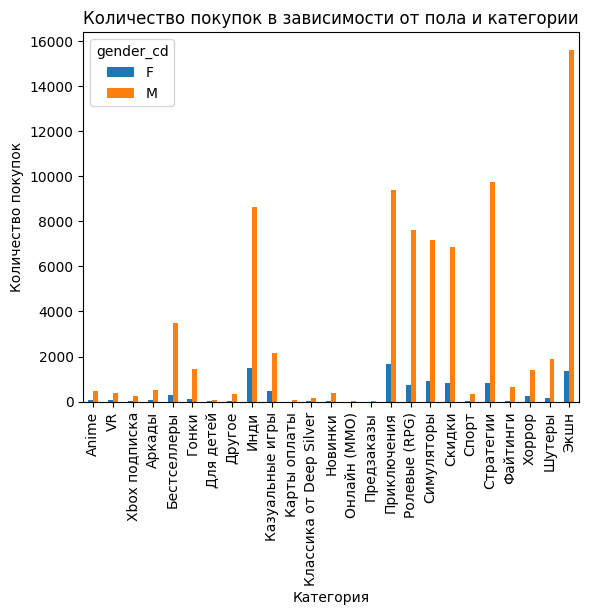

In [9]:
df2.groupby(['category_name', 'gender_cd']).size().unstack().plot(kind='bar')
plt.title('Количество покупок в зависимости от пола и категории')
plt.xlabel('Категория')
plt.ylabel('Количество покупок')
plt.show()

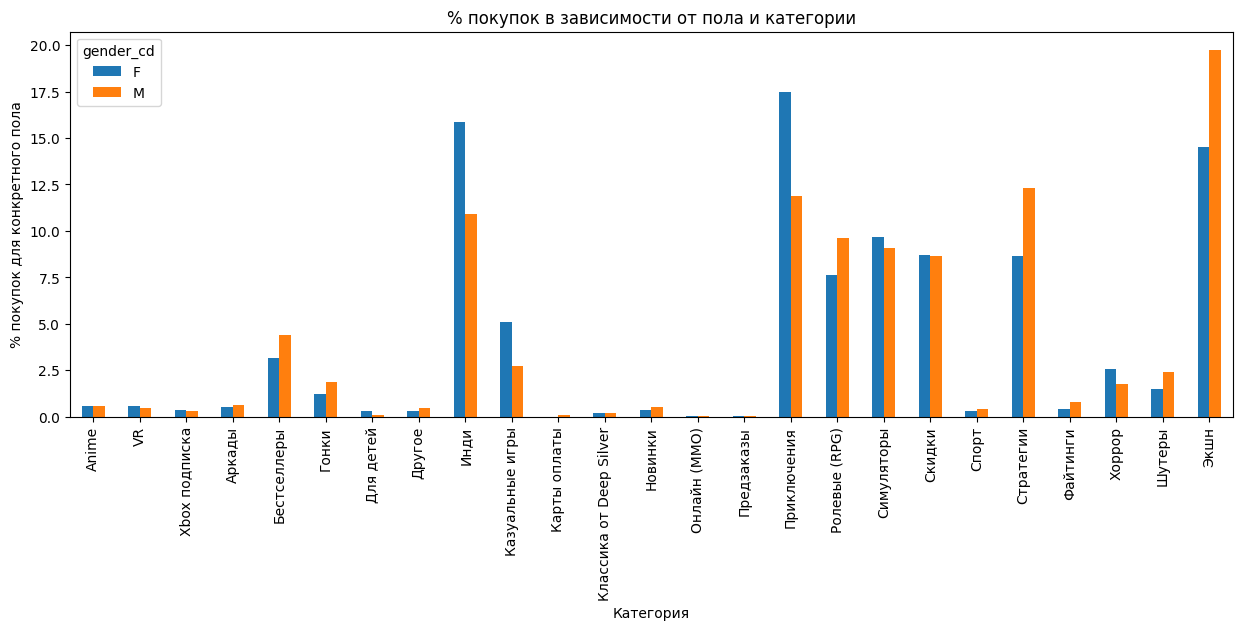

In [10]:
count_of_female_purchases = len(df2[df2['gender_cd'] == 'F'])
count_of_male_purchases = len(df2[df2['gender_cd'] == 'M'])
purchases_by_gender = df2.groupby(['category_name', 'gender_cd']).size().unstack()
purchases_by_gender['F'] *= 100 / count_of_female_purchases
purchases_by_gender['M'] *= 100 / count_of_male_purchases
purchases_by_gender.plot(kind='bar', stacked=False, figsize=(15, 5))
plt.title('% покупок в зависимости от пола и категории')
plt.xlabel('Категория')
plt.ylabel('% покупок для конкретного пола')
plt.show()

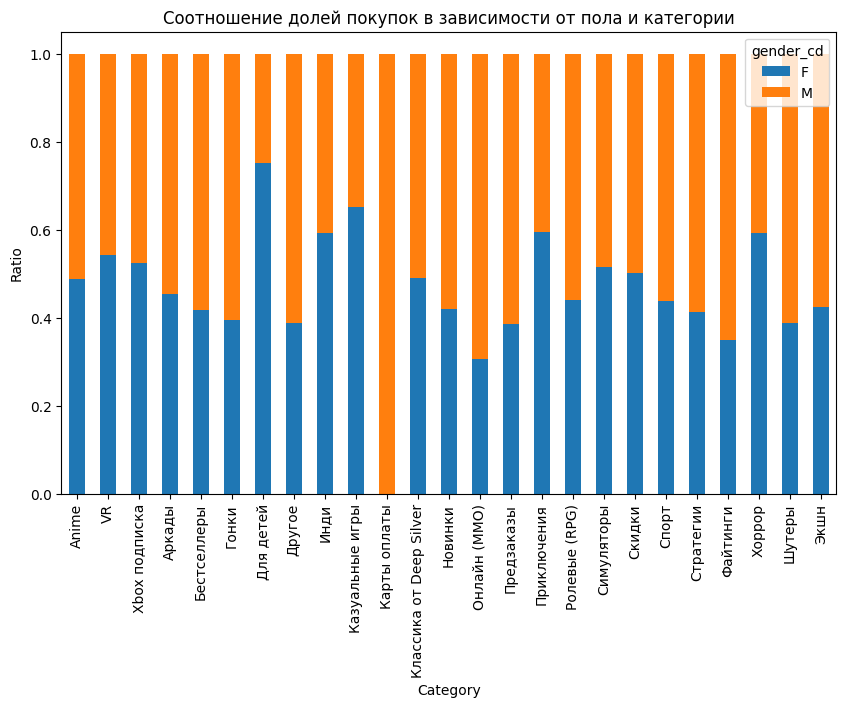

In [151]:
# purchases_by_gender = df.groupby(['category_name', 'gender_cd']).size().unstack()
count_of_female_purchases = len(df2[df2['gender_cd'] == 'F'])
count_of_male_purchases = len(df2[df2['gender_cd'] == 'M'])
purchases_by_gender = df2.groupby(['category_name', 'gender_cd']).size().unstack()
purchases_by_gender['F'] *= 100 / count_of_female_purchases
purchases_by_gender['M'] *= 100 / count_of_male_purchases
purchases_by_gender_ratio = purchases_by_gender.div(purchases_by_gender.sum(axis=1), axis=0)
purchases_by_gender_ratio.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Соотношение долей покупок в зависимости от пола и категории')
plt.xlabel('Category')
plt.ylabel('Ratio')
plt.show()


## Альтернативная гипотеза 2
Люди с высоким уровнем образования чаще покупают игры из категорий "стратегии" и "симуляторы", в то время как люди с низким уровнем образования чаще покупают игры из категорий "экшн" и "шутеры".

### Предобработка для этой гипотезы

In [114]:
df3 = df.copy()

In [115]:
edu_lvl_grade = {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}
edu_lvl_by_grade = {v: k for k, v in edu_lvl_grade.items()}

highest_edu_lvl_by_client = df.groupby('client_id')['education_level'].apply(
    lambda x: edu_lvl_by_grade[x.map(edu_lvl_grade).max()])
df3['education_level'] = df3['client_id'].map(highest_edu_lvl_by_client)

In [117]:
category_by_name = df.groupby('good_name')['category_name'].apply(lambda x: x.value_counts().index[0])
df3['category_name'] = df3['good_name'].map(category_by_name)

### Очистка выбросов для этой гипотезы

In [116]:
# Клиенты с образованием выше школьного и младше 18 лет
df3 = df3[(df3['age'] >= 18) | (df3['education_level'] == 'SCH')]

print(f'Размер датасета после фильтрации: {df3.shape[0] / df.shape[0] * 100:.2f}% от исходного')

Размер датасета после фильтрации: 88.63% от исходного


### Проверка гипотезы

In [166]:
print('Топ-3 категорий по количеству покупок в зависимости от образования')
df3.groupby(['education_level', 'category_name']).size().groupby(
    'education_level').nlargest(3).reset_index(level=0, drop=True).reset_index()

Топ-3 категорий по количеству покупок в зависимости от образования


,education_level,category_name,0
0,ACD,Экшн,205
1,ACD,Стратегии,166
2,ACD,Инди,137
3,GRD,Экшн,8396
4,GRD,Стратегии,6200
5,GRD,Инди,5360
6,PGR,Экшн,938
7,PGR,Стратегии,699
8,PGR,Приключения,685
9,SCH,Экшн,3885


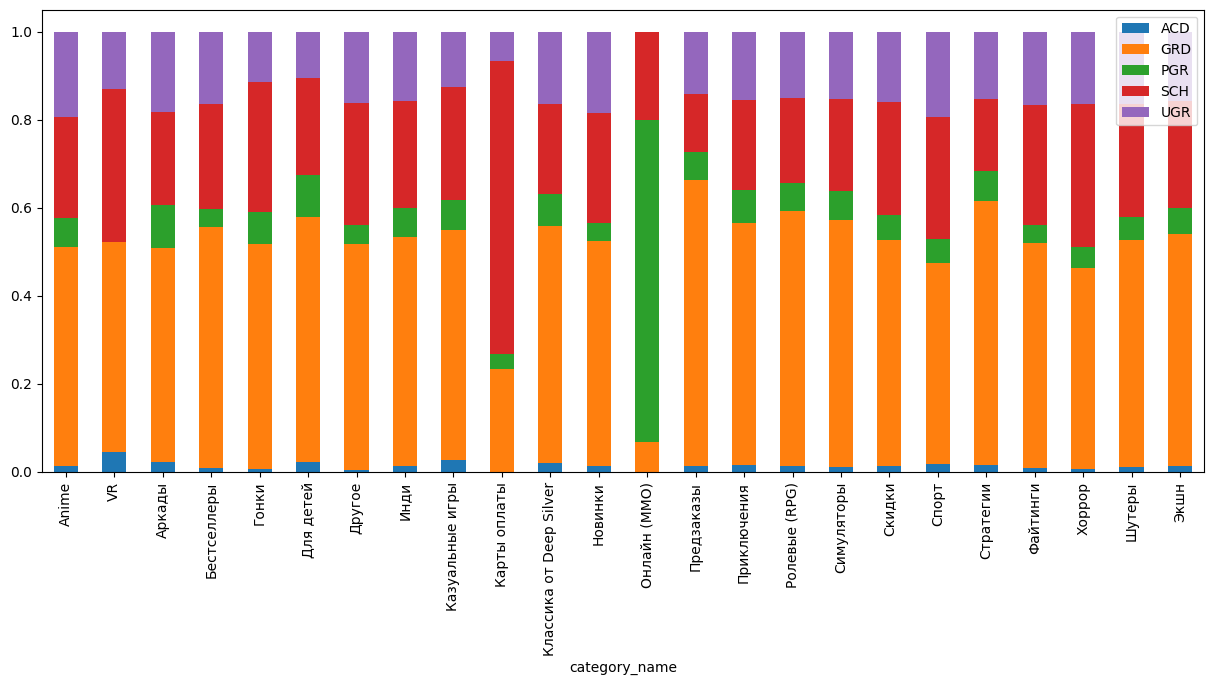

In [184]:
count_of_purchases_by_edu = df3.groupby('education_level').size()
purchases_by_edu = df3.groupby(['category_name', 'education_level']).size().unstack()
purchases_by_edu = purchases_by_edu.apply(lambda x: x * 100 / count_of_purchases_by_edu[x.name], axis=0)
purchases_by_edu_ratio = purchases_by_edu.div(purchases_by_edu.sum(axis=1), axis=0)
purchases_by_edu_ratio.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.legend(loc='upper right')
plt.show()

In [173]:
df3.groupby('category_name').size()

category_name
Anime                        429
VR                            23
Аркады                       514
Бестселлеры                 1302
Гонки                        865
Для детей                     95
Другое                       741
Инди                       10300
Казуальные игры             2272
Карты оплаты                  30
Классика от Deep Silver      195
Новинки                      448
Онлайн (MMO)                  15
Предзаказы                    77
Приключения                 9332
Ролевые (RPG)               6455
Симуляторы                  6935
Скидки                      7931
Спорт                        342
Стратегии                  10337
Файтинги                     635
Хоррор                      1317
Шутеры                      2088
Экшн                       15938
dtype: int64

# Прошлые наработки

<AxesSubplot: ylabel='gender_cd'>

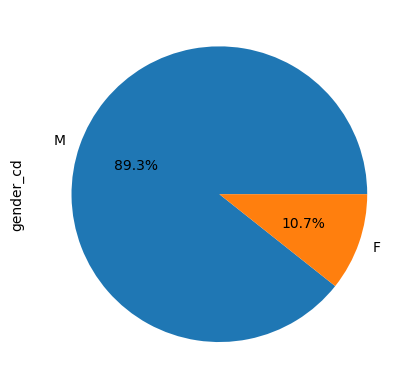

In [124]:
df['gender_cd'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [15]:
# Оставляем только клиентов старше 14 лет
df = df[df['age'] >= 14]

# Убираем клиентов с образованием не SCH и возрастом меньше 18 лет
df = df[(df['age'] >= 18) | (df['education_level'] == 'SCH')]


In [9]:
# more_than_3_age_clients = (df.groupby(['client_id', 'age']).size().unstack().isna().sum(axis=1) < 65).where(lambda x: x == True).dropna().index

# def f(x : tuple): return list(x[1]['age'].values) != list(x[1].sort_values(by='order_date')['age'].values)
# decreasing_age_clients = [x[0] for x in df.groupby('client_id')[['order_date', 'age']] if f(x)]

# strange_age_clients = list(set(more_than_3_age_clients) | set(decreasing_age_clients))  

In [14]:
# Клиентов с тремя и более различными образованиями
(df.groupby(['client_id', 'education_level']).size().unstack().isna().sum(axis=1) < 3).sum()
multieducation_clients = (df.groupby(['client_id', 'education_level']).size().unstack().isna().sum(axis=1) < 3).where(lambda x: x == True).dropna().index
len(multieducation_clients)
# df[df['client_id'].isin(multieducation_clients)].sort_values(['client_id', 'order_date']).head(10)
df = df[~df['client_id'].isin(multieducation_clients)]

In [10]:
# Клиентов с различными полами
multigender_clients = (df.groupby(['client_id', 'gender_cd']).size(
).unstack().isna().sum(axis=1) < 1).where(lambda x: x == True).dropna().index
len(multigender_clients)
# df[df['client_id'].isin(multigender_clients)].sort_values(['client_id', 'order_date']).head(10)
df = df[~df['client_id'].isin(multigender_clients)]

<AxesSubplot: xlabel='category_name'>

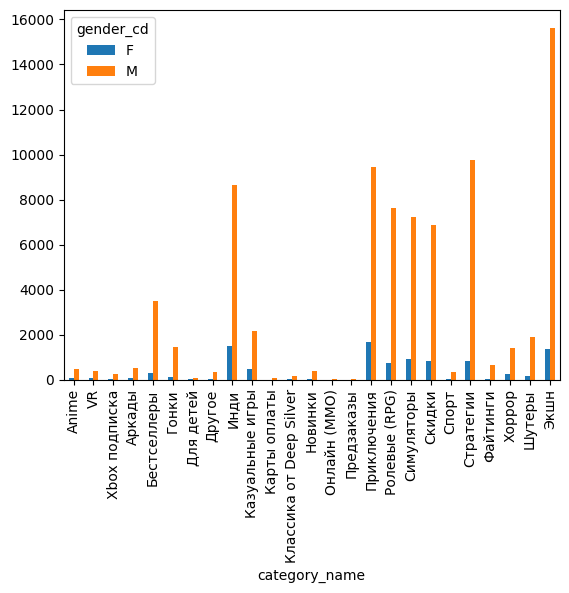

In [120]:
df2.groupby(['category_name', 'gender_cd']).size().unstack().plot(kind='bar')

<AxesSubplot: title={'center': 'Number of orders by month'}, xlabel='Month', ylabel='Count'>

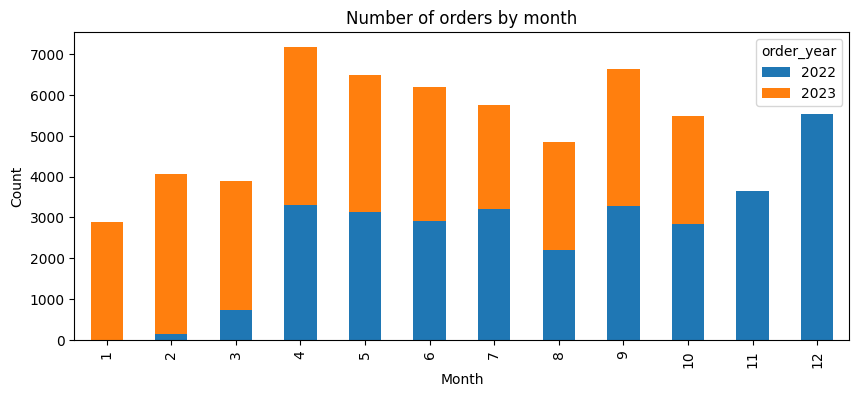

In [25]:
df.drop_duplicates(subset=['id']).groupby(['order_month', 'order_year']).size().unstack().plot(kind='bar', stacked=True, figsize=(10, 4), title='Number of orders by month', xlabel='Month', ylabel='Count')

<AxesSubplot: title={'center': 'Number of orders by good type'}>

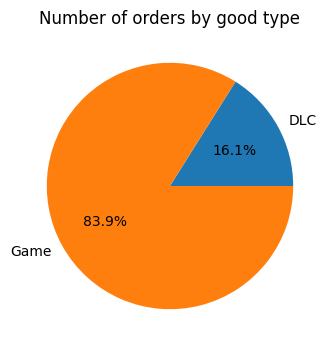

In [26]:
df.groupby('good_type').size().plot(kind='pie', figsize=(10, 4), title='Number of orders by good type', autopct='%1.1f%%')

<AxesSubplot: title={'center': 'Number of orders by category'}, xlabel='Category', ylabel='Count'>

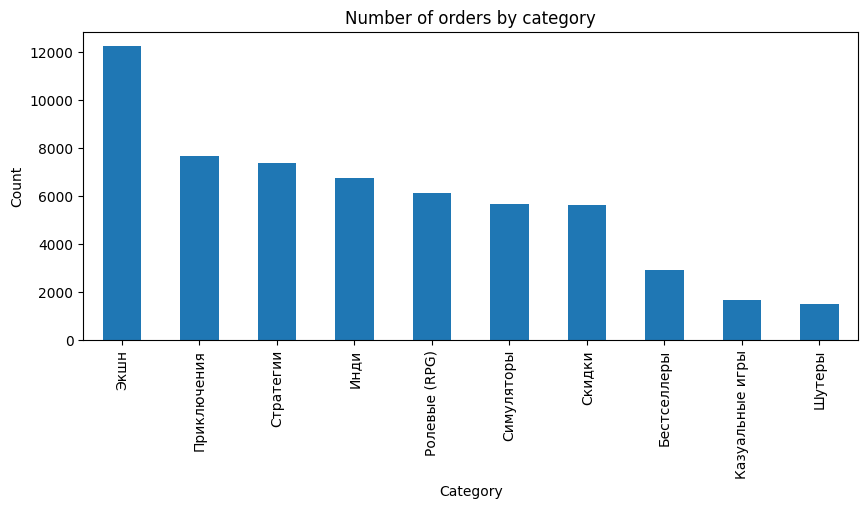

In [45]:
top_10_categories = df.groupby('category_name').size().sort_values(ascending=False).head(10).index
df[df['category_name'].isin(top_10_categories)].groupby('category_name').size().sort_values(ascending=False).plot(kind='bar', figsize=(10, 4), title='Number of orders by category', xlabel='Category', ylabel='Count')

C:\Users\tibec\AppData\Local\Temp\ipykernel_6976\4275309264.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('client_id').mean()[['monthly_income_amt', 'purchased_on_discount']].plot(kind='scatter', x='monthly_income_amt', y='purchased_on_discount', figsize=(10, 4), title='Monthly income and purchased on discount', xlabel='Mean monthly income', ylabel='Purchased on discount of all orders')


<AxesSubplot: title={'center': 'Monthly income and purchased on discount'}, xlabel='Mean monthly income', ylabel='Purchased on discount of all orders'>

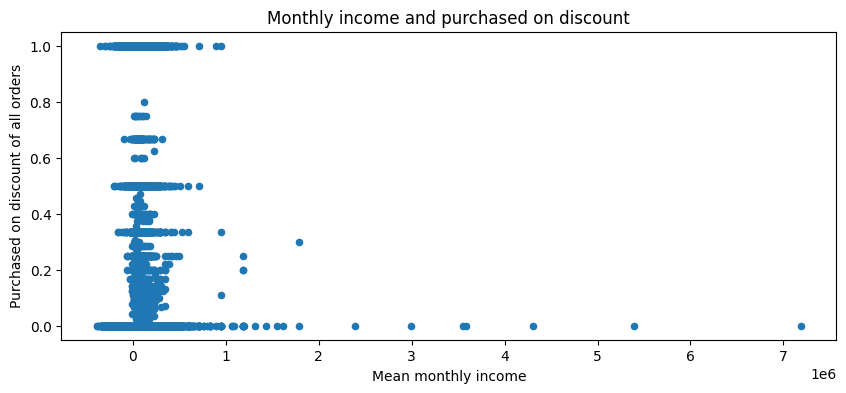

In [56]:
df.groupby('client_id').mean()[['monthly_income_amt', 'purchased_on_discount']].plot(kind='scatter', x='monthly_income_amt', y='purchased_on_discount', figsize=(10, 4), title='Monthly income and purchased on discount', xlabel='Mean monthly income', ylabel='Purchased on discount of all orders')

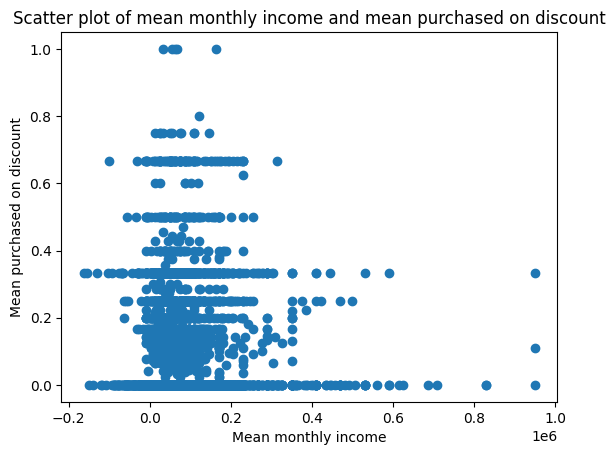

In [14]:
# Filter clients who have made more than 2 purchases
not_high_income_clients = df.groupby('client_id').filter(lambda x: x['monthly_income_amt'].mean() < 1000000)
filtered_df = not_high_income_clients.groupby('client_id').filter(lambda x: len(x) > 2)

# Calculate the mean values
mean_income = filtered_df.groupby('client_id')['monthly_income_amt'].mean()
mean_discount = filtered_df.groupby('client_id')['purchased_on_discount'].mean()

# Create the scatter plot
plt.scatter(mean_income, mean_discount)
plt.xlabel('Mean monthly income')
plt.ylabel('Mean purchased on discount')
plt.title('Scatter plot of mean monthly income and mean purchased on discount')
plt.show()


<AxesSubplot: title={'center': 'Number of orders by age'}, xlabel='Age', ylabel='Count'>

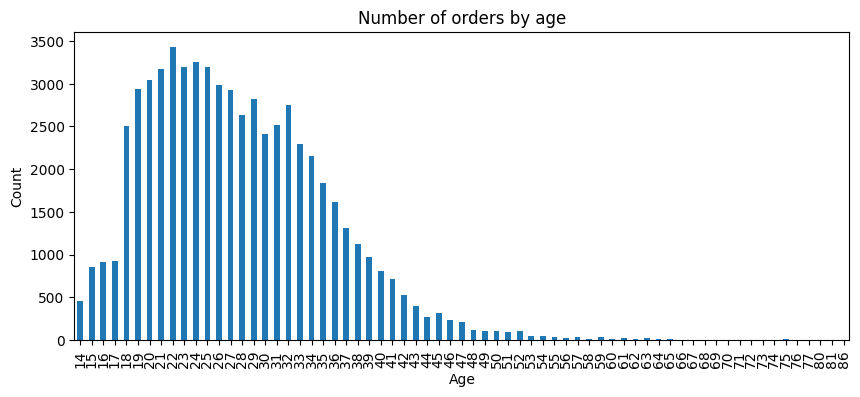

In [64]:
df.drop_duplicates(subset=['id']).groupby('age').size().plot(kind='bar', figsize=(10, 4), title='Number of orders by age', xlabel='Age', ylabel='Count')